# Import Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from spacy import displacy
from pyvis.network import Network
import networkx as nx
from collections import Counter
from community import community_louvain
import warnings
warnings.filterwarnings("ignore")

## Download english language model for spacy

In [2]:
# !python -m spacy download en_core_web_sm

In [3]:
# Load spacy English Langauge Model, NER --> Named Entity Recognition
nlp = spacy.load("en_core_web_sm")

In [4]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

# Load data

## Load books

In [5]:
pd.set_option("display.max_rows", None)

In [6]:
import os 
all_books = [b.name for b in os.scandir('data') if '.txt' in b.name]

In [7]:
all_books

['1 - The Last Wish.txt',
 '2 - The Sword of Destiny.txt',
 '3 - Blood of Elves.txt',
 '4 - Times of Contempt.txt',
 '5 - Baptism of Fire.txt',
 '6 - The Tower of the Swallow.txt',
 '7 - The Lady of the Lake.txt',
 '8 - Something Ends Something Begins.txt']

## Load characters data

In [8]:
characters_df = pickle.load(open("the_witcher_characters_data.pkl", "rb"))

In [9]:
characters_df.head(3)

,Book,Character
0,Category:Baptism of Fire characters,Adalia
1,Category:Baptism of Fire characters,Adela
2,Category:Baptism of Fire characters,Aen Saevherne


In [10]:
characters_df["character_firstname"] = characters_df["Character"].apply(lambda x: re.sub(r"\([^()]*\)", "", x))
characters_df["character_firstname"] = characters_df["Character"].apply(lambda x: x.split(" ")[0])

In [11]:
characters_df[:3]

,Book,Character,character_firstname
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen


### Find books with least characters and remove them 

In [12]:
least_character_books = list(characters_df.Book.value_counts()[-2:].index)
least_character_books

['Category:Szpony i kły characters',
 'Category:Tales from the world of The Witcher characters']

In [13]:
characters_df = characters_df[characters_df["Book"] != least_character_books[0]]
characters_df = characters_df[characters_df["Book"] != least_character_books[1]]

<AxesSubplot:>

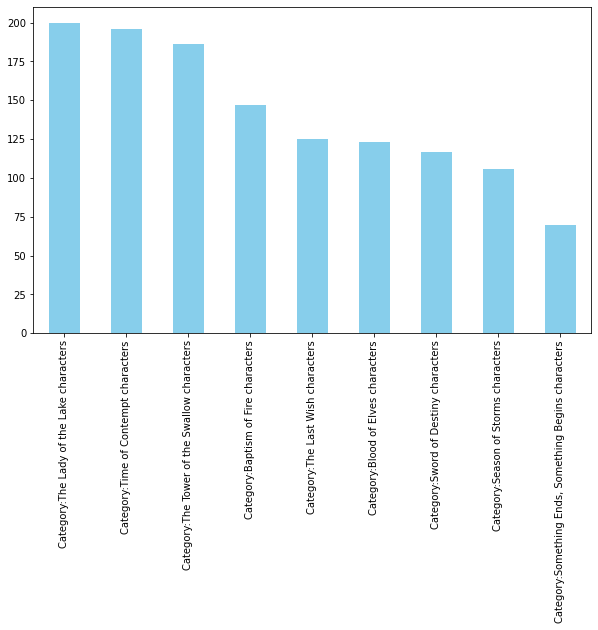

In [14]:
characters_df.Book.value_counts().plot(kind="bar", color="skyblue", figsize=(10,6), align="center")

# Named Entity Recognition

In [15]:
all_books = [book for book in all_books]
book_loc = [("data/" + book) for book in all_books]
book_loc

['data/1 - The Last Wish.txt',
 'data/2 - The Sword of Destiny.txt',
 'data/3 - Blood of Elves.txt',
 'data/4 - Times of Contempt.txt',
 'data/5 - Baptism of Fire.txt',
 'data/6 - The Tower of the Swallow.txt',
 'data/7 - The Lady of the Lake.txt',
 'data/8 - Something Ends Something Begins.txt']

In [16]:
book = book_loc[2]
book = open(book).read()
book_doc = nlp(book)

In [17]:
displacy.render(book_doc[:500], style="ent", jupyter=True)

# Extract relationships

## Get named entity list per sentence

In [18]:
def entity_per_sentence(book_doc) :
    sent_entity_df = []

    for sent in book_doc.sents :
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence" : sent, "entities" : entity_list})
    
    sent_entity_df = pd.DataFrame(sent_entity_df)
    return sent_entity_df

## Filter out non-characters entities

In [19]:
def filter_entities(ent_list, characters_df) :
    return [ent for ent in ent_list
           if ent in list(characters_df.Character) or
           ent in list(characters_df.character_firstname)]

## Create relationships

In [20]:
def create_relationships(sent_entity_filtered) :
    window_size = 5
    relationships = []

    for i in range(sent_entity_filtered.index[-1]) :
        end_i = min(i+5, sent_entity_filtered.index[-1])
        char_list = sum((sent_entity_filtered.iloc[i: end_i].character_entity), [])

        ## remove duplicated characters from the lists
        char_unique = list(Counter(char_list).keys())

        if len(char_unique)>1 :
            for idx, a in enumerate(char_unique[:-1]) :
                b = char_unique[idx+1]
                relationships.append({"source" : a, "target" : b})
    
    relationship_df = pd.DataFrame(relationships)
    return relationship_df

## Function to create relationship

In [21]:
def relationship(book_doc, characters_df) :
    sent_entities = entity_per_sentence(book_doc)
    
    sent_entities["character_entity"] = sent_entities["entities"].apply(lambda x: filter_entities(x, characters_df))

    ## removing sentences with no entities
    sent_entities_filtered = sent_entities[sent_entities["character_entity"].map(len)>0]

    ## take only first name of the characters
    sent_entities_filtered["character_entity"] = sent_entities_filtered["character_entity"].apply(lambda x: [item.split(" ")[0] for item in x])
    
    relationship_df = create_relationships(sent_entities_filtered)
    relationship_df = relationship_df.sort_values(by=["source", "target"])
    relationship_df["value"] = 1
    relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum()
    
    return relationship_df

In [ ]:
relationships = []

for i in range(len(book_loc)) :
    book = book_loc[i]
    book = open(book).read()
    book_doc = nlp(book)

    relationship_df = relationship(book_doc, characters_df)
    
    relationships.append({"Book" : book_loc[i].split("/")[1], "Relationship" : relationship_df})

In [ ]:
relationships[0]["Relationship"][:5]

# Visualizing character relationships

## Simple static network graph

In [ ]:
for i in range(len(relationships)) :
    G = nx.from_pandas_edgelist(df=relationships[i]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())

    plt.figure(figsize=(20,10))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
    plt.title(relationships[i]["Book"].split(".")[0], fontdict={"fontsize" : 30})
    plt.show()

## Dynamic relationship network graph

In [ ]:
def plot_relationships() :
    
    if os.path.exists("relationship_network/") :
        pass
    else :
        os.mkdir("relationship_network/")
        
    for i in range(len(relationships)) :
        G = nx.from_pandas_edgelist(df=relationships[i]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())

        net = Network(notebook=True, width="1200px", height="600px", bgcolor="#222222", font_color="white")

        node_degree = dict(G.degree)

        ## setting up node size attribute
        nx.set_node_attributes(G, node_degree, "size")

        net.from_nx(G)
        net.show("relationship_network/{book}.html".format(book=relationships[i]["Book"].split(".")[0]))

In [ ]:
plot_relationships()

# Most important characters

## Degree centrality

In [ ]:
for i in range(len(relationships)) :
    G = nx.from_pandas_edgelist(df=relationships[i]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())
    
    degree_dict = nx.degree_centrality(G)
    
    degree_df = pd.DataFrame.from_dict(degree_dict, orient="index", columns=["centrality"])
    degree_df_top_10 = degree_df.sort_values("centrality", ascending=False)[:9]
    
    plt.figure(figsize=(10,6))
    sns.set_theme(style="darkgrid")
    fig = sns.barplot(x=degree_df_top_10.index, y="centrality", data=degree_df_top_10)
    plt.title("{book} - Important Characters".format(book=relationships[i]["Book"].split(".")[0]), fontdict={"fontsize" : 15})
    plt.xlabel("Characters")
    plt.ylabel("Importance")
    plt.show()

## Betweenness Centrality

In [ ]:
for i in range(len(relationships)) :
    G = nx.from_pandas_edgelist(df=relationships[i]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())
    
    degree_dict = nx.betweenness_centrality(G)
    
    degree_df = pd.DataFrame.from_dict(degree_dict, orient="index", columns=["centrality"])
    degree_df_top_10 = degree_df.sort_values("centrality", ascending=False)[:9]
    
    plt.figure(figsize=(10,6))
    sns.set_theme(style="darkgrid")
    fig = sns.barplot(x=degree_df_top_10.index, y="centrality", data=degree_df_top_10)
    plt.title("{book} - Important Characters".format(book=relationships[i]["Book"].split(".")[0]), fontdict={"fontsize" : 15})
    plt.xlabel("Characters")
    plt.ylabel("Importance")
    plt.show()

## Closeness Centrality

In [ ]:
for i in range(len(relationships)) :
    G = nx.from_pandas_edgelist(df=relationships[i]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())
    
    degree_dict = nx.closeness_centrality(G)
    
    degree_df = pd.DataFrame.from_dict(degree_dict, orient="index", columns=["centrality"])
    degree_df_top_10 = degree_df.sort_values("centrality", ascending=False)[:9]
    
    plt.figure(figsize=(10,6))
    sns.set_theme(style="darkgrid")
    fig = sns.barplot(x=degree_df_top_10.index, y="centrality", data=degree_df_top_10)
    plt.title("{book} - Important Characters".format(book=relationships[i]["Book"].split(".")[0]), fontdict={"fontsize" : 15})
    plt.xlabel("Characters")
    plt.ylabel("Importance")
    plt.show()

# Community Detection

In [ ]:
G = nx.from_pandas_edgelist(df=relationships[0]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())

communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, "group")
com_net = Network(height="800px", width="1500px", notebook=True, bgcolor="#222222", font_color="white")
com_net.from_nx(G)
com_net.show("{book}.html".format(book=relationships[0]["Book"]))

In [ ]:
def plot_community_network() :
    
    if os.path.exists("community_network/") :
        pass
    else :
        os.mkdir("community_network/")
    
    for i in range(len(relationships)) :
        G = nx.from_pandas_edgelist(df=relationships[i]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())

        communities = community_louvain.best_partition(G)
        nx.set_node_attributes(G, communities, "group")
        com_net = Network(height="750px", width="1500px", notebook=True, bgcolor="#222222", font_color="white")
        com_net.from_nx(G)
        com_net.show("community_network/{book}.html".format(book=relationships[i]["Book"].split(".")[0]))

In [ ]:
plot_community_network()

# Importance of character over time

In [ ]:
degree_centrality_books = []
for i in range(len(relationships)) :
    G = nx.from_pandas_edgelist(df=relationships[i]["Relationship"], source="source", target="target", edge_attr="value", create_using=nx.Graph())

    degree_dict = nx.degree_centrality(G)
    l_dict = len(degree_dict.keys())
    book_degree_centrality = pd.DataFrame(degree_dict, index=[0]).transpose()
    book_degree_centrality = book_degree_centrality.reset_index()    
    book_degree_centrality.columns = ["character", "importance"]
    
    degree_centrality_books.append({"Book" : relationships[i]["Book"], "Importance" : book_degree_centrality})

In [ ]:
degree_centrality_books[7]["Importance"][degree_centrality_books[7]["Importance"]["character"]=="Geralt"]

In [ ]:
def importance_of_character(*characters) :
    data = pd.DataFrame()
    
    for character in characters :
        for book in degree_centrality_books :
            data = data.append(book["Importance"][book["Importance"]["character"]==character], ignore_index=True)
    
    
            
    return data

In [ ]:
importance_of_character("Geralt")